# Random ODE Generator

## Setting Problem Up

In [1]:
### Imports ###
import numpy as np
from sympy import *
import sympy
import random as rand
import random
import IPython.display as disp
init_printing()
import matplotlib.pyplot as plt

In [2]:
### Setting predetermined values ###

# Setting the order of the equation (fixed)
n = 3

########

# Number of y-type terms (x, y, y', etc.)
T = n + 2

# Minimum number of subterms total (total number of terms in the final equation)
min_subterms = 2

# Maximum number of subterms total (total number of terms in the final equation)
max_subterms = 3

# Maximum number of times a function recursively called to create a function
max_fun = 2

# Sets the cumulative probabilities for the following function types:
# (1) No change (2) power (3) exponential (4) logarithmic (5) trig (6) hyperbolic
function_cdf = [0.1, 0.5, 0.62, 0.74, 1, 1]

# Sets the probability that the function creating function will recursively call
# itself again
recurs_prob = 0.1

# The probability of adding a constant to the function
add_c_prob = 0.5

In [3]:
### Defining the symbols, functions, and terms ###

# Define symbol and function variables
x = Symbol('x')

# Stores the y-type terms (x, y, y', etc.) in an array called y_terms
y_terms = np.empty(T, dtype=Symbol)
y_terms[0] = x

for i in range(1, T):
    #y_terms[i] = y(x).diff(x, i - 1)
    y_terms[i] = Symbol('y'+str(i-1))
    
y_terms

array([x, y0, y1, y2, y3], dtype=object)

## Functions

In [4]:
def num_subterms (sum_min, sum_max):
    '''
    This creates an array of the number of subterms for each y-type term.
    If the number of subterms is less than the specified minimum or greater than
    the specified maximum, the function will call itself recursively until
    a valid number of subterms are determined.

    Parameters
    ----------
    sum_min:  int
              The minimum number of total subterms
    sum_max:  int
              The maximum number of total subterms

    Returns
    ----------
    temp: numpy array of int
          Returns the number of subterms for each y-type term
    '''

    temp = np.empty(T, dtype=int)
    # Initially set that the nth derivative term has one subterm
    temp[-1] = 1

    # Set number of subterms (0, 1, or 2) for remaining terms
    for i in range(T - 1):
        # Sets the probability of having 0 subterms or 1 subterm
        probabilities = [0] * 1 + [1] * 2
        temp[i] = rand.choice(probabilities)

    if (sum(temp) < sum_min or sum_min > sum_max):
        return num_subterms (sum_min, sum_max)
    # return temp
    return [1, 1, 1, 1, 1] # changed this so every order is present in the final ODE

In [210]:
def add_coeff_and_constant(subterm, const_prob = 0.5):
    # Determines coefficient
    coeffs = np.linspace(-5,-1,11, dtype=int)
    if rand.random() < 0.5:
        subterm *= rand.choice(coeffs)
    # elif rand.random() > 0.8:
    #     subterm /= rand.choice(coeffs)

    # Determines added constant
    if rand.random() < const_prob:
        subterm += rand.choice(coeffs)

    return subterm

In [214]:
def generate_random_sympy_polynomial():
    """
    Generates a simple sympy polynomial of x with two or three terms and a maximum power of 4.
    Coefficients range from -5 to 5.

    Returns:
        sympy.Expr: A sympy expression representing the polynomial.
    """

    x = symbols('x')
    num_terms = random.choice([2, 3])
    polynomial = 0

    for _ in range(num_terms):
        coeff = random.choice([i for i in range(-5, 6) if i != 0])
        power = random.randint(0, 4)
        polynomial += coeff * x**power

    return add_coeff_and_constant(polynomial, 1)

# Generate and display a sympy polynomial
random_sympy_polynomial = generate_random_sympy_polynomial()
random_sympy_polynomial

In [6]:
def polynomial_from_coefficients(coefficients, special_func_prob=0.5, power_prob=0.5):
    """
    Converts a list of coefficients into a polynomial expression using sympy.
    Optionally adds a special function to the polynomial.

    Parameters:
    coefficients (list): A list of coefficients, where the index represents the power of x.
    special_func_prob (float): Probability of adding a special function to the polynomial.
    power_prob (float): Probability of raising the special function to a positive power.

    Returns:
    sympy expression: The polynomial expression.
    """
    x = symbols('x')
    polynomial = sum(coef * x**i for i, coef in enumerate(coefficients[::-1]))

    # Check if a special function should be added
    if random.random() < special_func_prob:
        # List of special functions
        special_funcs = [sin(x), cos(x), log(x+1), exp(x)]
        # Choose one special function randomly
        special_func = random.choice(special_funcs)

        # Optionally raise the special function to a positive power
        if random.random() < power_prob:
            power = random.randint(1, 4)  # positive power between 1 and 4
            special_func = special_func**power

        # Add the special function to the polynomial
        polynomial += special_func

    return Poly(polynomial)

In [206]:
def create_subterm (y_term, cdf, iteration, max_it, const_prob):
    '''
    This returns a random subterm (a random function of the given y_term).
    It may recursively call itself to make a more complicated funciton up to
    max_it times.

    The drawable functions include power, exponential, logarithmic,
    trigonometric, and hyperbolic.

    Parameters
    ----------
    y_term:     Object
                The y-type term (x, y, y', etc.)
    cdf:        int
                The cumulative pobability of each function type (power,
                exponential, logarithmic, trigonometric, and hyperbolic)
    iteration:  int
                The iteration number (how many times the function has
                been called)
    max_it:     int
                The maximum number of times the function can be called
    const_prob: float
                The probability of adding a constant to the current subterm

    Returns
    ----------
    subterm:  Object
              Returns a subterm for a function of a given y_term
    '''

    # Default value (function does nothing)
    subterm = y_term

    # RETURNING y3 alone
    if y_term == y_terms[4]:
        return y_terms[4]

    # Randomly determines if a function must be applied (and which function)
    temp = rand.random()
    
    # New Feature: Raise y, y', or y'' to a positive power
    if y_term in [y_terms[1], y_terms[2], y_terms[3]]:
        if rand.random() < 0.5:  # the probability of raising to a power
            power = rand.randint(1, 3)  # positive power between 1 and 4
            subterm = y_term ** power
            return simplify(subterm)
        else:
            polynomial = generate_random_sympy_polynomial()
            print(polynomial)
            subterm = 1 / polynomial * y_term
            return simplify(subterm)

    if y_term == y_terms[0]:
        # Trig
        if temp > 0.5:
            # trig_fun = [sin(y_term)] + [cos(y_term)] + [tan(y_term)]
            trig_fun = [sin(y_term)] + [cos(y_term)]
            polynomial = generate_random_sympy_polynomial()
            print(polynomial)
            subterm = 1/(polynomial + rand.choice(trig_fun))
            # subterm = add_coeff_and_constant(subterm, const_prob)
            return simplify(subterm)
        # Exponential
        else:
            subterm = 1/exp(y_term)
            subterm = add_coeff_and_constant(subterm, const_prob)
            return simplify(subterm)
        # f(x)
        # elif temp > cdf[0]:
        #     coefficients = generate_polynomial(degree=4, num_terms=2,coeff_lower_bound=-3,coeff_upper_bound=3)
        #     subterm = 1 / polynomial_from_coefficients(coefficients) * y_term


    if subterm == 0:
        return create_subterm(y_term, cdf, iteration, max_it, const_prob)

    # Will consider reiterating if we have not yet reached the maximum
    # number of iterations

    # if iteration < max_it:
    #     # If so, will add another function on top of this one
    #     if rand.random() < recurs_prob:
    #         # Recursively calls its own function to
    #         # create a more complicated function
    #         subterm = create_subterm(subterm, cdf, iteration + 1, max_it, const_prob)
    #     # If not, will randomly determine if some additional p(x) should be added
    #     elif rand.random() < 2/3:
    #         # Only p(x)
    #         subterm *= create_subterm(x, cdf, max_it, max_it, const_prob)

    return simplify(subterm)

In [207]:
def create_subterms (y_term, num_sub):
    # print(y_term)
    '''
    This returns all subterms of the equation.

    Parameters
    ----------
    y_term:   numpy array of Object
              The y-type terms (x, y, y', etc.)
    num_sub:  numpy array of int
              The number of subterms for each y-type term

    Returns
    ----------
    subterms: numpy array of Object
              Returns all of the subterms for the equation
    '''

    # Stores the subterms
    subterms = np.empty(sum(num_sub), dtype=Mul)

    # Keeps track of index of subterms we are at
    counter = 0

    for i, y_t in enumerate(y_term):
        # print(num_sub[i])
        for n_s in range(num_sub[i]):
            # Determines function to be applied to the y_term
            subterms[counter] = create_subterm(y_t, function_cdf, 1, max_fun, add_c_prob)
            counter += 1

    return subterms

## Final Calculation and Output

In [160]:
terms = create_subterms(y_terms, num_subterms(min_subterms, max_subterms))
print("The terms are:")
for i in range(len(terms)):
    disp.display(terms[i])

The terms are:


In [88]:
y3 = y_terms[4]
new_terms = terms.tolist()
new_terms.remove(y3)
new_terms

In [89]:
y3 = -sum(new_terms)

In [90]:
y3

12*x**4 - 12*x**2 - 4
x**2 - 2


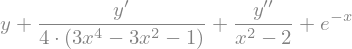

None

\text{Approximate the solution to the third-order ODE: } y''' = y + \frac{y'}{4 \cdot \left(3 x^{4} - 3 x^{2} - 1\right)} + \frac{y''}{x^{2} - 2} + e^{- x}

\text{With initial conditions at } x = 0:
\begin{align*}
y(0) &= 1.00 \\
y'(0) &= 0.00 \\
y''(0) &= 0.00
\end{align*}

-y0 - y1/(4*(3*x**4 - 3*x**2 - 1)) - y2/(x**2 - 2) - exp(-x)


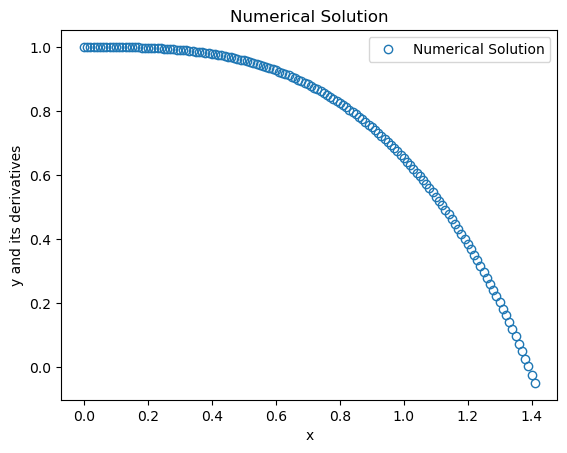

In [224]:
from sympy import symbols, diff, exp
from scipy.integrate import solve_ivp

x = symbols('x')
y, y0, y1, y2, y3 = symbols('y y0 y1 y2 y3')

from sympy.utilities.lambdify import lambdify

terms = create_subterms(y_terms, num_subterms(min_subterms, max_subterms))

# Define the mapping for replacement
replacement_mapping = {
    y0: y,
    y1: symbols("y'"),
    y2: symbols("y''"),
    y3: 0
}

# Function to replace y0, y1, y2 with y, y', y''
def replace_with_differential(expr):
    return expr.subs(replacement_mapping)

replaced_expr = replace_with_differential(sum(terms))

print(disp.display(replaced_expr))

# Converting the replaced expression to LaTeX
latex_replaced_expr = latex(replaced_expr)

# Extracting the values a, b, c from init_condition
a, b, c = [1,0,0]

# Preparing the updated LaTeX formatted equation with x_0 as 0 and the new form of the equation
updated_latex_equation = f"""
\\text{{Approximate the solution to the third-order ODE: }} y''' = {latex_replaced_expr}

\\text{{With initial conditions at }} x = 0:
\\begin{{align*}}
y(0) &= {a:.2f} \\\\
y'(0) &= {b:.2f} \\\\
y''(0) &= {c:.2f}
\\end{{align*}}
"""

print(updated_latex_equation)

y3 = y_terms[4]
new_terms = terms.tolist()
new_terms.remove(y3)
y3 = -sum(new_terms)

print(y3)

# Lambdify the y3 expression so it can be used as a function
y3_func = lambdify((x, y0, y1, y2), y3)

# Define the system of first-order ODEs using y3 directly
def system_of_odes_with_y3(x, y):
    y0, y1, y2 = y
    # Use y3 as a function
    dy2_dx = y3_func(x, y0, y1, y2)
    return [y1, y2, dy2_dx]

initial_conditions = [1, 0, 0]  # placeholder initial conditions
x_range = (0, 100)
X = np.linspace(x_range[0], x_range[1], 10000)

# Solve the system of ODEs
solution_with_y3 = solve_ivp(system_of_odes_with_y3, x_range, initial_conditions, t_eval=X)

plt.plot(solution_with_y3.t, solution_with_y3.y[0], 'o', mfc='none', label='Numerical Solution')
# plt.plot(solution_with_y3.t, solution_with_y3.y[1], label="y'(x)")
# plt.plot(solution_with_y3.t, solution_with_y3.y[2], label="y''(x)")
plt.legend()
plt.xlabel('x')
plt.ylabel('y and its derivatives')
plt.title('Numerical Solution')
plt.show()

In [180]:
def find_divergence_x_value(solution, component_index=0, threshold=1e3):
    y_values = solution.y[component_index]
    for i, y in enumerate(y_values):
        if abs(y) > threshold:
            return solution.t[i], i
    return None, None  # Return None if the solution does not diverge within the given range

# Example usage:
div_point, index = find_divergence_x_value(solution_with_y3, component_index=0)
if div_point is not None:
    print(f"The solution diverges at x = {div_point}")
else:
    print("The solution does not diverge within the given range")


The solution does not diverge within the given range


In [200]:
def find_divergence_x_value(solution, component_index=0, threshold=1e3):
    return solution.t[-1], solution.y[0,-1]

div_point, index = find_divergence_x_value(solution_with_y3, component_index=0)
if div_point is not None:
    print(f"The solution diverges at x = {div_point}")
else:
    print("The solution does not diverge within the given range")

The solution diverges at x = 3.9403940394039405


**Plotting the dominant balances**

In [49]:
terms

array([log(x + 1), y0/(x + 4), y1, y2/(4*x + 3), y3], dtype=object)

In [50]:
from sympy import lambdify, symbols, log
import numpy as np

# Define the symbols used in the expressions
x, y0, y1, y2 = symbols('x y0 y1 y2')

# Your array of expressions
terms = np.array([log(x + 1) - 3, x**2*y0*(x - 4), y1**2, y2*(-4*x**4 - 4*x**3 + 1)], dtype=object)

# Convert each expression to a function
term_funcs = [lambdify((x, y0, y1, y2), term) for term in terms]

# Assuming solution_with_y3 is your solution object from solve_ivp
x_values = solution_with_y3.t
y_values0 = solution_with_y3.y[0]
y_values1 = solution_with_y3.y[1]
y_values2 = solution_with_y3.y[2]

# Evaluate each function with the numerical solutions
evaluated_terms = [func(x_values, y_values0, y_values1, y_values2) for func in term_funcs]

# y_values3 is calculated as the sum of all the other evaluated terms
y_values3 = sum(evaluated_terms)

# Now you can access each term
term1, term2, term3, term4 = evaluated_terms
list_of_terms = [term1, term2, term3, term4]
term5 = y_values3


In [51]:
solution_with_y3.t

array([ 0.        ,  0.15151515,  0.3030303 ,  0.45454545,  0.60606061,
        0.75757576,  0.90909091,  1.06060606,  1.21212121,  1.36363636,
        1.51515152,  1.66666667,  1.81818182,  1.96969697,  2.12121212,
        2.27272727,  2.42424242,  2.57575758,  2.72727273,  2.87878788,
        3.03030303,  3.18181818,  3.33333333,  3.48484848,  3.63636364,
        3.78787879,  3.93939394,  4.09090909,  4.24242424,  4.39393939,
        4.54545455,  4.6969697 ,  4.84848485,  5.        ,  5.15151515,
        5.3030303 ,  5.45454545,  5.60606061,  5.75757576,  5.90909091,
        6.06060606,  6.21212121,  6.36363636,  6.51515152,  6.66666667,
        6.81818182,  6.96969697,  7.12121212,  7.27272727,  7.42424242,
        7.57575758,  7.72727273,  7.87878788,  8.03030303,  8.18181818,
        8.33333333,  8.48484848,  8.63636364,  8.78787879,  8.93939394,
        9.09090909,  9.24242424,  9.39393939,  9.54545455,  9.6969697 ,
        9.84848485, 10.        , 10.15151515, 10.3030303 , 10.45

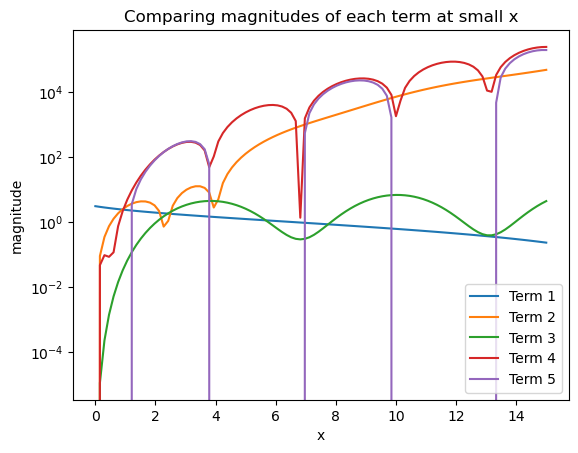

In [52]:
for i in range(len(list_of_terms)):
    plt.plot(solution_with_y3.t, abs(list_of_terms[i]), label = f"Term {i+1}");

plt.plot(solution_with_y3.t, term5, label = "Term 5");
plt.xlabel('x')
plt.ylabel('magnitude')
# plt.xlim([0,3])
plt.yscale("log")
plt.title("Comparing magnitudes of each term at small x")
plt.legend();

In [53]:
div_point

For the small x regime, the dominant terms are determined by looking at the point div_point / 4 (arbitrarily chosen, but to prevent it from going into other intermediate regimes) 

In [54]:
solution_with_y3.t.size

In [55]:
index

In [56]:
import heapq

The method below finds the dominant balance at a variable x position

In [57]:
endpoint_values = []
for i in range(len(list_of_terms)):
    endpoint_values.append(abs(list_of_terms[i])[round(index/8)]) # adding the points to do dominant balance at

largest = heapq.nlargest(2, endpoint_values) 

# get the indices of the two largest elements
index1 = endpoint_values.index(largest[0])
index2 = endpoint_values.index(largest[1])

print(index1+1, index2+1) # these are the dominant terms

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

It might be better to fix x at something like $x=0.01$ for where to compute the dominant balance at.

In [58]:
solution_with_y3.t

# Target value
target_x = 0.1

# Find the index of the value closest to target_x
index_closest = np.argmin(np.abs(x_values - target_x))

# index_closest is the index of the closest value
print("Index of the value closest to x=0.01:", index_closest)

endpoint_values = []
for i in range(len(list_of_terms)):
    endpoint_values.append(abs(list_of_terms[i])[index_closest]) # adding the points to do dominant balance at

largest = heapq.nlargest(2, endpoint_values) 

# get the indices of the two largest elements
index1 = endpoint_values.index(largest[0])
index2 = endpoint_values.index(largest[1])

print(index1+1, index2+1) # these are the dominant terms

Index of the value closest to x=0.01: 1
1 2


In [59]:
terms[index1]